In [1]:
# import numpy and pandas, and DataFrame / Series
import math
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import scipy.optimize as optimize

# Set some numpy options
np.set_printoptions(suppress=True)

# Set some pandas options
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

# And some items for matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
#pd.options.display.mpl_style = 'default'

In [2]:
# Setup the parameters you will use for this part of the exercise
input_layer_size  = 400;  # 20x20 Input Images of Digits
hidden_layer_size = 25;   # 25 hidden units
num_labels = 10;          # 10 labels, from 1 to 10   
                          # (note that we have mapped "0" to label 10)

## =========== Part 1: Loading and Visualizing Data =============
###  We start the exercise by first loading and visualizing the dataset. 
###  You will be working with a dataset that contains handwritten digits.

In [3]:
X = np.loadtxt('mlclass-ex4/X.csv', delimiter=',')
y = np.loadtxt('mlclass-ex4/y.csv', delimiter=',')

m = len(y)
y=np.resize(y, (m,1))
y.shape

#% Randomly select 100 data points to display
rand_indices=np.random.permutation(m)

sel = X[rand_indices[1:100], :]
print("X shape: {0}".format(X.shape))
print("y shape: {0}".format(y.shape))


X shape: (5000, 400)
y shape: (5000, 1)


In [4]:
def displayData(X, example_width=None):
#DISPLAYDATA Display 2D data in a nice grid
#   [h, display_array] = DISPLAYDATA(X, example_width) displays 2D data
#   stored in X in a nice grid. It returns the figure handle h and the 
#   displayed array if requested.

    # Set example_width automatically if not passed in
    if example_width == None:
        example_width = round(math.sqrt(X.shape[1]));

    # Compute rows, cols
    m = X.shape[0]
    n = X.shape[1]
    example_height = round(n / example_width)
    
    # Compute number of items to display
    display_rows = math.floor(math.sqrt(m));
    display_cols = math.ceil(m / display_rows);

    # Between images padding
    pad = 1;
    
    # Setup blank display
    display_array = - np.ones((pad + (display_rows * (example_height + pad)), pad + (display_cols * (example_width + pad))))

    # Copy each example into a patch on the display array
    curr_ex = 0;
    for j in np.arange(display_rows):
        for i in np.arange(display_cols):
            if curr_ex > m : 
                break; 
            # Copy the patch

            # Get the max value of the patch
            max_val = np.amax(abs(X[curr_ex, :]));
            display_array_startx = j * (example_width + pad) #pad + (j * (example_height + pad)) - 1
            display_array_endx = ((j + 1) * (example_width + pad)) -1 # pad + (j * (example_height + pad))
            display_array_starty = i * (example_height + pad) # pad + (i * (example_width + pad))
            display_array_endy = ((i +1) * (example_height + pad)) - 1
                    
            de = (np.array(X[curr_ex, :]).reshape((example_width, example_height))) / max_val
            #print de.shape
            display_array[display_array_startx:display_array_endx, display_array_starty:display_array_endy] = (np.array(X[curr_ex, :]).reshape((example_width, example_height))).T / max_val;
            curr_ex = curr_ex + 1;
        
        if curr_ex > m:
            break; 


    # Display Image
    plt.imshow(display_array, extent = [0,100,0,100], aspect='auto', cmap=plt.get_cmap('gray'))
    plt.show

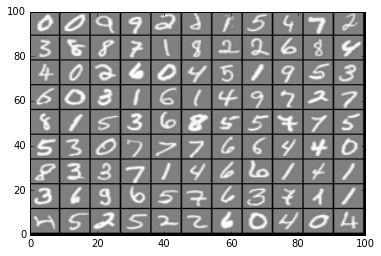

In [5]:
displayData(sel);

## %% ================ Part 2: Loading Parameters ================
### % In this part of the exercise, we load some pre-initialized 
### % neural network parameters.

In [6]:
print('\nLoading Saved Neural Network Parameters ...\n')

# Load the weights into variables Theta1 and Theta2
Theta1 = np.loadtxt('mlclass-ex4/Theta1.csv', delimiter=',')
print("Theta1 size: {0}".format(Theta1.shape))

Theta2 = np.loadtxt('mlclass-ex4/Theta2.csv', delimiter=',')
print("Theta2 size: {0}".format(Theta2.shape))

# Unroll parameters 
nn_params = np.hstack((Theta1.flatten(order='F'), Theta2.flatten(order='F')))

print("nn_params size: {0}".format(nn_params.shape))



Loading Saved Neural Network Parameters ...

Theta1 size: (25, 401)
Theta2 size: (10, 26)
nn_params size: (10285,)


### %% ================ Part 3: Compute Cost (Feedforward) ================
## %  To the neural network, you should first start by implementing the
## %  feedforward part of the neural network that returns the cost only. You
## %  should complete the code in nnCostFunction.m to return cost. After
## %  implementing the feedforward to compute the cost, you can verify that
## %  your implementation is correct by verifying that you get the same cost
## %  as us for the fixed debugging parameters.
## %
## %  We suggest implementing the feedforward cost *without* regularization
## %  first so that it will be easier for you to debug. Later, in part 4, you
## %  will get to implement the regularized cost.
## %

In [7]:
def sigmoid(z):
#SIGMOID Compute sigmoid functoon
#   J = SIGMOID(z) computes the sigmoid of z.
    
    g = 1.0 / (1.0 + np.exp(-z));
    return g

def sigmoidGradient(z):
#SIGMOID Compute sigmoid functoon
#   J = SIGMOID(z) computes the sigmoid of z.
    
    g  = sigmoid(z) * (1-sigmoid(z))
    return g

In [8]:
# See Lecture 51
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lamda):
    # %NNCOSTFUNCTION Implements the neural network cost function for a two layer
    # %neural network which performs classification
    # %   [J grad] = NNCOSTFUNCTON(nn_params, hidden_layer_size, num_labels, ...
    # %   X, y, lambda) computes the cost and gradient of the neural network. The
    # %   parameters for the neural network are "unrolled" into the vector
    # %   nn_params and need to be converted back into the weight matrices. 
    # % 
    # %   The returned parameter grad should be a "unrolled" vector of the
    # %   partial derivatives of the neural network.
    # %

    # % Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # % for our 2 layer neural network
    
    Theta1 = nn_params[0:hidden_layer_size*(input_layer_size+1)].reshape((hidden_layer_size, (input_layer_size+1)), order='F')
    # print(Theta1.shape)
    
    
    Theta2 = nn_params[hidden_layer_size*(input_layer_size+1):].reshape((num_labels, (hidden_layer_size+1)), order='F')
    # print(Theta2.shape)
    
    # Setup some useful variables
    m = X.shape[0]
    
    # You need to return the following variables correctly 
    J = 0;
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)
    
    # % ====================== YOUR CODE HERE ======================
    # % Instructions: You should complete the code by working through the
    # %               following parts.
    # %
    # % Part 1: Feedforward the neural network and return the cost in the
    # %         variable J. After implementing Part 1, you can verify that your
    # %         cost function computation is correct by verifying the cost
    # %         computed in ex4.m
    # %
    # % Part 2: Implement the backpropagation algorithm to compute the gradients
    # %         Theta1_grad and Theta2_grad. You should return the partial derivatives of
    # %         the cost function with respect to Theta1 and Theta2 in Theta1_grad and
    # %         Theta2_grad, respectively. After implementing Part 2, you can check
    # %         that your implementation is correct by running checkNNGradients
    # %
    # %         Note: The vector y passed into the function is a vector of labels
    # %               containing values from 1..K. You need to map this vector into a 
    # %               binary vector of 1's and 0's to be used with the neural network
    # %               cost function.
    # %
    # %         Hint: We recommend implementing backpropagation using a for-loop
    # %               over the training examples if you are implementing it for the 
    # %               first time.
    # %
    # % Part 3: Implement regularization with the cost function and gradients.
    # %
    # %         Hint: You can implement this around the code for
    # %               backpropagation. That is, you can compute the gradients for
    # %               the regularization separately and then add them to Theta1_grad
    # %               and Theta2_grad from Part 2.
    # %    
    
    a1 = np.hstack((np.ones((m,1)), X)) # (5000 x 401)
    z2 = a1.dot(Theta1.T)
    a2 = sigmoid(z2) # (5000 x 401) x (401 x 25) = 5000 x 25
    a2 = np.hstack((np.ones((a2.shape[0], 1)), a2)) # 5000 x 26    
    z3 = a2.dot(Theta2.T)
    a3 = sigmoid(z3) # (5000 x 26) x (26 x 10) = 5000 x 10
    h = a3
    
    # Explode y into 10 values with Y[i] := i == y.
    Y = np.zeros((m, num_labels)) # 5000 x 10
    for i in np.arange(m):
        Y[i, int(np.mod(y[i,0],num_labels))] = 1
    
    tmp = 1/m*np.sum(np.sum(-(Y*np.nan_to_num(np.log(h)))-(1-Y)*np.nan_to_num(np.log(1-h))))
    
    J_int = tmp + (lamda/(2*m))*np.sum(np.sum(Theta1[:, 1:] * Theta1[:, 1:])) 
    J = J_int + (lamda/(2*m))*np.sum(np.sum(Theta2[:, 1:] * Theta2[:, 1:])) 
    
    # 2. Backpropagate to get gradient information.
    s3 = h - Y;  # 5000 x 10
    s2 = sigmoidGradient(np.hstack((np.ones((z2.shape[0], 1)), z2))) # (5000 x 401) x (401 x 25) = 5000 x 25 +1 
    s2 = s3.dot(Theta2) * s2 # 5000 x 26

    # Vectorized ftw:
    Theta2_grad = (1/m) * s3.T.dot(a2) # ?? 10 x 26
    Theta1_grad = (1/m) * s2[:,1:].T.dot(a1) # ?? 25 x 5000 x 500 x 401 = 25 x 401
    
    p2 = (lamda/m) * np.hstack((np.zeros((Theta2.shape[0],1)), Theta2[:, 1:])) # (5000 x 401)    
    p1 = (lamda/m) * np.hstack((np.zeros((Theta1.shape[0],1)), Theta1[:, 1:])) # (5000 x 401)
 
    Grad2 = Theta2_grad + p2
    
    Grad1 = Theta1_grad + p1
    
    #  % Unroll gradients
    grad = np.hstack((Grad1.flatten(order='F'), Grad2.flatten(order='F')))
    
    return (J, grad)

In [9]:
print('\nFeedforward Using Neural Network ...\n')

# Weight regularization parameter (we set this to 0 here).
lamda = 0

(J, g) = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, 
                   num_labels, X, y, lamda)

print("Cost at parameters (loaded from ex4weights): {0}\n(this value should be about 0.287629)\n".format(J))


Feedforward Using Neural Network ...

Cost at parameters (loaded from ex4weights): 10.44145967277798
(this value should be about 0.287629)



In [10]:
# %% =============== Part 4: Implement Regularization ===============
# %  Once your cost function implementation is correct, you should now
# %  continue to implement the regularization with the cost.
# %

print('\nChecking Cost Function (w/ Regularization) ... \n')

# % Weight regularization parameter (we set this to 1 here).
lamda = 1;

(J, g) = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, 
                   num_labels, X, y, lamda);

print("Cost at parameters (loaded from ex4weights): {0}\n(this value should be about 0.383770)\n".format(J))


Checking Cost Function (w/ Regularization) ... 

Cost at parameters (loaded from ex4weights): 10.537600366707585
(this value should be about 0.383770)



In [11]:
# %% ================ Part 5: Sigmoid Gradient  ================
# %  Before you start implementing the neural network, you will first
# %  implement the gradient for the sigmoid function. You should complete the
# %  code in the sigmoidGradient.m file.
# %

print('\nEvaluating sigmoid gradient...\n')

g = sigmoidGradient(np.array([1, -0.5, 0 ,0.5, 1]))
print('Sigmoid gradient evaluated at [1 -0.5 0 0.5 1]:\n  ')
print("{0}".format(g))
print('\n\n')

print("Program paused. Press enter to continue.\n")


Evaluating sigmoid gradient...

Sigmoid gradient evaluated at [1 -0.5 0 0.5 1]:
  
[ 0.19661193  0.23500371  0.25        0.23500371  0.19661193]



Program paused. Press enter to continue.



In [12]:
def randInitializeWeights(L_in, L_out):
# %RANDINITIALIZEWEIGHTS Randomly initialize the weights of a layer with L_in
# %incoming connections and L_out outgoing connections
# %   W = RANDINITIALIZEWEIGHTS(L_in, L_out) randomly initializes the weights 
# %   of a layer with L_in incoming connections and L_out outgoing 
# %   connections. 
# %
# %   Note that W should be set to a matrix of size(L_out, 1 + L_in) as
# %   the first row of W handles the "bias" terms
# %
    
    epsilon_init = 0.12;
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init;
    
    return W


In [13]:
# %% ================ Part 6: Initializing Pameters ================
# %  In this part of the exercise, you will be starting to implment a two
# %  layer neural network that classifies digits. You will start by
# %  implementing a function to initialize the weights of the neural network
# %  (randInitializeWeights.m)

print('\nInitializing Neural Network Parameters ...\n')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size);
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels);

# % Unroll parameters
initial_nn_params = np.hstack((initial_Theta1.flatten(), initial_Theta2.flatten()))


Initializing Neural Network Parameters ...



In [14]:
def debugInitializeWeights(fan_out, fan_in):
# %DEBUGINITIALIZEWEIGHTS Initialize the weights of a layer with fan_in
# %incoming connections and fan_out outgoing connections using a fixed
# %strategy, this will help you later in debugging
# %   W = DEBUGINITIALIZEWEIGHTS(fan_in, fan_out) initializes the weights 
# %   of a layer with fan_in incoming connections and fan_out outgoing 
# %   connections using a fix set of values
# %
# %   Note that W should be set to a matrix of size(1 + fan_in, fan_out) as
# %   the first row of W handles the "bias" terms
# %

# % Set W to zeros
    W = np.zeros((fan_out, 1 + fan_in))

# % Initialize W using "sin", this ensures that W is always of the same
# % values and will be useful for debugging
    W = np.sin(np.arange(1,(W.shape[0]*W.shape[1])+1)).reshape(W.shape, order='F')/10

# % =========================================================================
    return W

In [15]:
def computeNumericalGradient(J, theta):
# %COMPUTENUMERICALGRADIENT Computes the gradient using "finite differences"
# %and gives us a numerical estimate of the gradient.
# %   numgrad = COMPUTENUMERICALGRADIENT(J, theta) computes the numerical
# %   gradient of the function J around theta. Calling y = J(theta) should
# %   return the function value at theta.

# % Notes: The following code implements numerical gradient checking, and 
# %        returns the numerical gradient.It sets numgrad(i) to (a numerical 
# %        approximation of) the partial derivative of J with respect to the 
# %        i-th input argument, evaluated at theta. (i.e., numgrad(i) should 
# %        be the (approximately) the partial derivative of J with respect 
# %        to theta(i).)
# %                

    numgrad = np.zeros(theta.shape)
    perturb = np.zeros(theta.shape)
    e = 1e-4;
    for p in np.arange(0,theta.size):
        # % Set perturbation vector
        perturb[p] = e;
        (loss1, blank) = J(theta - perturb);
        (loss2, blank) = J(theta + perturb);
        # % Compute Numerical Gradient
        numgrad[p] = (loss2 - loss1) / (2*e);
        perturb[p] = 0;

    return numgrad

In [16]:
def checkNNGradients(lamda=0):
# %CHECKNNGRADIENTS Creates a small neural network to check the
# %backpropagation gradients
# %   CHECKNNGRADIENTS(lambda) Creates a small neural network to check the
# %   backpropagation gradients, it will output the analytical gradients
# %   produced by your backprop code and the numerical gradients (computed
# %   using computeNumericalGradient). These two gradient computations should
# %   result in very similar values.
# %

    try:
        lamda
    except NameError:
        lamda = 0
    
    input_layer_size = 3;
    hidden_layer_size = 5;
    num_labels = 3;
    m = 5;

    # % We generate some 'random' test data
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size) # (5,3)
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size) #(3, 5)
    # Reusing debugInitializeWeights to generate X
    X  = debugInitializeWeights(m, input_layer_size - 1) #(5, 4)
    y  = 1 + np.mod(np.array(np.arange(1,m+1)), num_labels).T

    y = y.reshape(len(y),1)

    # % Unroll parameters
    nn_params = np.hstack((Theta1.flatten(order='F'), Theta2.flatten(order='F')))
    # % Short hand for cost function
    #costFunc = @(p) nnCostFunction(p, input_layer_size, hidden_layer_size, ...
    #                           num_labels, X, y, lambda);
    
    def cf2(input_layer_size, hidden_layer_size, num_labels, X, y, lamda):
        def cf(p):
            return nnCostFunction(p, input_layer_size, hidden_layer_size, 
                               num_labels, X, y, lamda)
        return cf    

    
    costFunc = cf2(input_layer_size, hidden_layer_size, num_labels, X, y, lamda)

    (cost, grad) = costFunc(nn_params);
    numgrad = computeNumericalGradient(costFunc, nn_params);

    # % Visually examine the two gradient computations.  The two columns
    # % you get should be very similar. 
    print(numgrad)
    print(grad)
    
    print('The above two columns you get should be very similar.\n', 
         '(Left-Your Numerical Gradient, Right-Analytical Gradient)\n\n')

    # % Evaluate the norm of the difference between two solutions.  
    # % If you have a correct implementation, and assuming you used EPSILON = 0.0001 
    # % in computeNumericalGradient.m, then diff below should be less than 1e-9
    diff = np.linalg.norm(numgrad-grad)/np.linalg.norm(numgrad+grad);

    print('If your backpropagation implementation is correct, then \n',
         'the relative difference will be small (less than 1e-9). \n',
         "\nRelative Difference: {0}\n".format(diff))

In [17]:
# %% =============== Part 7: Implement Backpropagation ===============
# %  Once your cost matches up with ours, you should proceed to implement the
# %  backpropagation algorithm for the neural network. You should add to the
# %  code you've written in nnCostFunction.m to return the partial
# %  derivatives of the parameters.
# %
print('\nChecking Backpropagation... \n');

#%  Check gradients by running checkNNGradients
checkNNGradients()

print('\nProgram paused. Press enter to continue.\n')


Checking Backpropagation... 

[-0.01028673  0.01055649 -0.01063964  0.01047526 -0.01010633 -0.00002913
  0.00002106 -0.00001353  0.00000552  0.0000034  -0.00009326  0.00009363
 -0.00009227  0.00008901 -0.00008367 -0.00002378  0.00003206 -0.00003881
  0.00004498 -0.00005086  0.11454497  0.31105659  0.0974007   0.05937786
  0.16227578  0.05046841  0.05970555  0.16274645  0.05065569  0.05779723
  0.15658245  0.04904527  0.05540534  0.14944693  0.04711758  0.05473138
  0.14790553  0.04664534]
[-0.01028673  0.01055649 -0.01063964  0.01047526 -0.01010633 -0.00002913
  0.00002106 -0.00001353  0.00000552  0.0000034  -0.00009326  0.00009363
 -0.00009227  0.00008901 -0.00008367 -0.00002378  0.00003206 -0.00003881
  0.00004498 -0.00005086  0.11454497  0.31105659  0.0974007   0.05937786
  0.16227578  0.05046841  0.05970555  0.16274645  0.05065569  0.05779723
  0.15658245  0.04904527  0.05540534  0.14944693  0.04711758  0.05473138
  0.14790553  0.04664534]
The above two columns you get should be v

In [18]:
# %% =============== Part 8: Implement Regularization ===============
# %  Once your backpropagation implementation is correct, you should now
# %  continue to implement the regularization with the cost and gradient.
# %

print('\nChecking Backpropagation (w/ Regularization) ... \n')

# %  Check gradients by running checkNNGradients
lamda = 3;
checkNNGradients(lamda);
y = y.reshape(len(y),1)
# % Also output the costFunction debugging values
(cost_debug_J, grad_debug_J)  = nnCostFunction(nn_params, input_layer_size,  hidden_layer_size, num_labels, X, y, lamda);

print("\n\nCost at (fixed) debugging parameters (w/ lambda = 10): {0}\n(this value should be about 0.576051)\n\n".format(cost_debug_J))

print('Program paused. Press enter to continue.\n');


Checking Backpropagation (w/ Regularization) ... 

[-0.01028673  0.01055649 -0.01063964  0.01047526 -0.01010633 -0.01679406
  0.03944026  0.05934796  0.02473263 -0.03263787 -0.06009267 -0.03210074
  0.02511775  0.05952545  0.0389336  -0.01729798 -0.05765179 -0.04509805
  0.00903761  0.05472585  0.11454497  0.31105659  0.0974007   0.01396971
  0.10474033  0.03370348  0.09912475  0.22210794  0.0753828   0.02515596
  0.09658304  0.01685089  0.08061536  0.20888337  0.08613485  0.03745719
  0.09022168  0.00158611]
[-0.01028673  0.01055649 -0.01063964  0.01047526 -0.01010633 -0.01679406
  0.03944026  0.05934796  0.02473263 -0.03263787 -0.06009267 -0.03210074
  0.02511775  0.05952545  0.0389336  -0.01729798 -0.05765179 -0.04509805
  0.00903761  0.05472585  0.11454497  0.31105659  0.0974007   0.01396971
  0.10474033  0.03370348  0.09912475  0.22210794  0.0753828   0.02515596
  0.09658304  0.01685089  0.08061536  0.20888337  0.08613485  0.03745719
  0.09022168  0.00158611]
The above two column

In [19]:
#%% =================== Part 8: Training NN ===================
#%  You have now implemented all the code necessary to train a neural
#%  network. To train your neural network, we will now use "fmincg", which
#%  is a function which works similarly to "fminunc". Recall that these
#%  advanced optimizers are able to train our cost functions efficiently as
#%  long as we provide them with the gradient computations.
#%
print('\nTraining Neural Network... \n')

# %  After you have completed the assignment, change the MaxIter to a larger
# %  value to see how more training helps.
# options = optimset('MaxIter', 50);

# %  You should also try different values of lambda
lamda = 1;
 
options = {'maxiter': 1000}
# Try 'CG', 'BFGS', 'L-BFGS-B'
Result = optimize.minimize(fun = nnCostFunction, x0 = initial_nn_params, args = (input_layer_size, hidden_layer_size, num_labels, X, y, lamda), method = 'L-BFGS-B',
                                 #jac = lrCostGradFunction, options=options)
                                 jac=True, options=options)

nn_params = Result.x


# Obtain Theta1 and Theta2 back from nn_params
Theta1 = nn_params[0:hidden_layer_size*(input_layer_size+1)].reshape((hidden_layer_size, (input_layer_size+1)), order='F')
# print(Theta1.shape)
    
    
Theta2 = nn_params[hidden_layer_size*(input_layer_size+1):].reshape((num_labels, (hidden_layer_size+1)), order='F')

print('Program paused. Press enter to continue.\n');


Training Neural Network... 

Program paused. Press enter to continue.



In [20]:
# %% ================= Part 9: Visualize Weights =================
# %  You can now "visualize" what the neural network is learning by
# %  displaying the hidden units to see what features they are capturing in
# %  the data.

print('\nVisualizing Neural Network... \n')

df = pd.DataFrame(Theta1[:, 1:])

print(df.head(10))




Visualizing Neural Network... 

            0             1             2         3         4         5    \
0  1.736957e-07  1.731924e-07  1.746105e-06  0.000006 -0.000328 -0.002954   
1 -7.953657e-08  7.333795e-08 -2.467284e-06  0.000071 -0.000586 -0.005668   
2 -6.006021e-08  1.452209e-07  4.118389e-07 -0.000040  0.000378  0.002940   
3 -3.818268e-07 -2.730860e-07  1.012140e-06 -0.000045  0.000483  0.004049   
4  2.096907e-07 -3.580616e-07  3.369605e-06 -0.000018 -0.000214 -0.001428   
5  2.966616e-08  2.074470e-07 -4.807347e-06  0.000032  0.000175  0.001275   
6  3.137188e-07  1.694394e-07 -1.006688e-05  0.000051  0.000545  0.004838   
7 -2.381486e-07  2.296751e-07 -1.295996e-06  0.000025 -0.000123 -0.001204   
8  1.645225e-07  3.414639e-07  2.547971e-06 -0.000033 -0.000002  0.001199   
9 -4.517663e-08 -3.844848e-07 -6.996832e-07  0.000015 -0.000152 -0.001020   

        6         7         8         9         10        11        12   \
0  0.002120  0.000251 -0.001412 -0.003940 -0

In [21]:
def predict(Theta1, Theta2, X):
#%PREDICT Predict the label of an input given a trained neural network
#%   p = PREDICT(Theta1, Theta2, X) outputs the predicted label of X given the
#%   trained weights of a neural network (Theta1, Theta2)

#% Useful values
    m = X.shape[0]
    num_labels = Theta2.shape[0]

#% You need to return the following variables correctly 
    p = np.zeros((m, 1))

    h1 = sigmoid(np.hstack((np.ones((m, 1)), X)).dot(Theta1.T))
    h2 = sigmoid(np.hstack((np.ones((m, 1)), h1)).dot(Theta2.T))
    
    
    p = np.argmax(h2, axis=1)

#% =========================================================================
    return p





Training Set Accuracy: 99.72


Displaying Example Image

(400,)

Neural Network Prediction: %d (digit %d)
 [8] 8.0


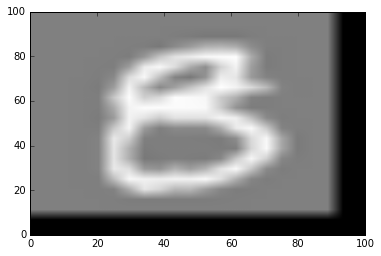

In [26]:
# %% ================= Part 10: Implement Predict =================
# %  After training the neural network, we would like to use it to predict
# %  the labels. You will now implement the "predict" function to use the
# %  neural network to predict the labels of the training set. This lets
# %  you compute the training set accuracy.

pred = predict(Theta1, Theta2, X);

print("\nTraining Set Accuracy: {0}\n".format(np.mean(pred == (np.mod(y[:,0],num_labels))) * 100)) 


#%  To give you an idea of the network's output, you can also run
#%  through the examples one at the a time to see what it is predicting.

#%  Randomly permute examples
rp = np.random.permutation(m)
for i in np.arange(1):
    # % Display
    print('\nDisplaying Example Image\n');
    print
    sel2 = X[rp[i], :]
    displayData(sel2.reshape(1,sel2.shape[0]));

    pred = predict(Theta1, Theta2, sel2.reshape(1,sel2.shape[0]));
    print('\nNeural Network Prediction: %d (digit %d)\n', np.mod(pred,num_labels), np.mod(y[rp[i],0], num_labels))

In [27]:
pred = predict(Theta1, Theta2, X);
print(pred[0:10])

[0 0 0 0 0 0 0 0 0 0]


In [28]:
print(y[500:510,0].T-1)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [32]:
np.sum(np.mod(pred, num_labels) != np.mod(y[:,0], num_labels))

14

In [33]:
print(np.mod(pred[0], num_labels), np.mod(y[0], num_labels))

0 [ 0.]
